# Chapter 9: Probabilities and the Bayesian approach


## The probability that a coin is fair
In this example, we use Bayes' theorem to decide if a coin is fair, based on a result. For example, if we obtained 7 heads in 10 coin tosses, we want to know the probability that the coin is fair; in other words, what is the probability that given then result, the probability of getting heads is $p=0.5$.

Using Bayes' theorem, we want the probability that the coin has a certain value $p$ given our result (e.g. 7 heads in 10 coin tosses):

$$ P(p| result) \propto P(result|p)P(p) $$

Where we do not need to worry about the $\frac{1}{P(result)}$ normalization term. 

The likelihood, $P(result|p)$ is simply given by the binomial probability. For the prior, $P(p)$, we can assume that we have no prior knowledge and that $P(p)=1$ for $p$ between 0 and 1, and 0 otherwise.

In python, we can easily find the posterior, probability density function, $P(p| result)$, by calculating the binomial probability of the result for different values of $p$ and then multiplying by the prior (1 in this case):


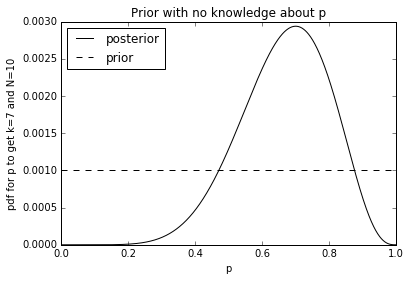

In [1]:
import scipy.stats as stats
import numpy as np
import pylab as pl
%matplotlib inline

k=7
N=10
#An array of many values of p
p = np.linspace(0,1,1000)
#The corresponding likelihood for different values
pbinom = stats.binom.pmf(k,N,p)
prior = stats.uniform.pdf(p)
#multiply by the prior (not very useful here!)
posterior = pbinom*prior
#normalize the posterior and prior when plotting
pl.plot(p,posterior/posterior.sum(),color='black',label='posterior')
pl.plot(p,prior/prior.sum(),'--',color='black',label='prior')
pl.xlabel('p')
pl.ylabel('pdf for p to get k={:.0f} and N={:.0f}'.format(k,N))
pl.legend(loc='best')
pl.title("Prior with no knowledge about p")
pl.show()

Using the posterior probability for p to get the probability that p likes in the range 0.45 to 0.55

In [6]:
#Define a range for p
pmin = 0.45
pmax = 0.55
#Find the indices of the array p that correspond to those values
ipmin = (np.abs(p-pmin)).argmin()
ipmax = (np.abs(p-pmax)).argmin()
#To get the probability, we sum the posterior for all values in the range
#and then divide by the sum of all elements to ensure that the probability is normalized
prob = pbinom[ipmin:ipmax].sum()/pbinom.sum()
print("The probability that p is between {:.2f} and {:.2f} is {:.1f}%".format(p[ipmin],p[ipmax],100*prob))

The probability that p is between 0.45 and 0.55 is 12.8%


Comparing the posterior probabilities if our prior is that the coin is likely fair or likely biased 

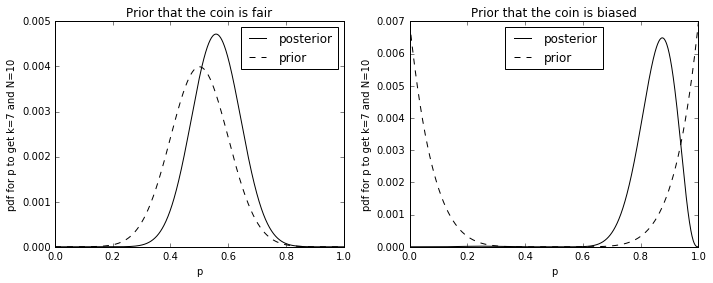

In [13]:
#Let's start with an assumption that the coin is likely fair, with p normally distributed about 0.5 with std=0.1
prior_fair = stats.norm.pdf(p,0.5,0.1)
posterior_fair = pbinom*prior_fair

pl.figure(figsize=(10,4))
pl.subplot(121)

#We normalize the prior and posterior to have the same area
pl.plot(p,posterior_fair/posterior_fair.sum(),color='black',label='posterior')
pl.plot(p,prior_fair/prior_fair.sum(),'--',color='black',label='prior')
pl.xlabel('p')
pl.ylabel('pdf for p to get k={:.0f} and N={:.0f}'.format(k,N))
pl.legend(loc='best')
pl.title("Prior that the coin is fair")

#Let's compare with the assumption that the coin is likely unfair (p=0 or 1 are more likely)
prior_unfair = (p-0.5)**6
posterior_unfair = pbinom*prior_unfair

#We normalize the prior and posterior to have the same area
pl.subplot(122)
pl.plot(p,posterior_unfair/posterior_unfair.sum(),color='black',label='posterior')
pl.plot(p,prior_unfair/prior_unfair.sum(),'--',color='black',label='prior')
pl.xlabel('p')
pl.ylabel('pdf for p to get k={:.0f} and N={:.0f}'.format(k,N))
pl.legend(loc='upper center')
pl.title("Prior that the coin is biased")

pl.tight_layout()
pl.show()




Finally, we reproduce the case when k=70 and N=100, where the data now have a much more significant impact:

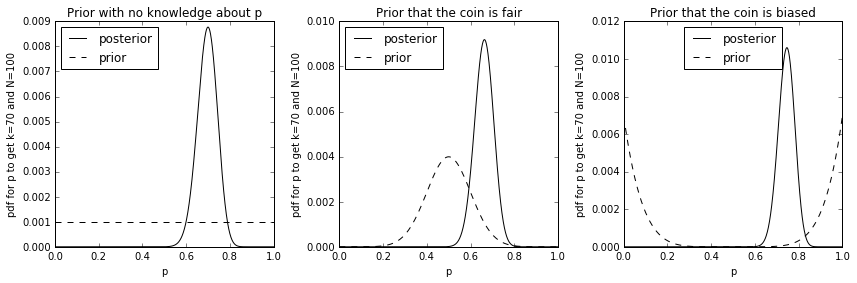

In [16]:
k=70
N=100

pbinom = stats.binom.pmf(k,N,p)

#Flat prior
pl.figure(figsize=(12,4))
pl.subplot(131)
prior = stats.uniform.pdf(p)
#multiply by the prior (not very useful here!)
posterior = pbinom*prior
#normalize the posterior and prior when plotting
pl.plot(p,posterior/posterior.sum(),color='black',label='posterior')
pl.plot(p,prior/prior.sum(),'--',color='black',label='prior')
pl.xlabel('p')
pl.ylabel('pdf for p to get k={:.0f} and N={:.0f}'.format(k,N))
pl.legend(loc='best')
pl.title("Prior with no knowledge about p")

prior_fair = stats.norm.pdf(p,0.5,0.1)
posterior_fair = pbinom*prior_fair

pl.subplot(132)

#We normalize the prior and posterior to have the same area
pl.plot(p,posterior_fair/posterior_fair.sum(),color='black',label='posterior')
pl.plot(p,prior_fair/prior_fair.sum(),'--',color='black',label='prior')
pl.xlabel('p')
pl.ylabel('pdf for p to get k={:.0f} and N={:.0f}'.format(k,N))
pl.legend(loc='best')
pl.title("Prior that the coin is fair")

#Let's compare with the assumption that the coin is likely unfair (p=0 or 1 are more likely)
prior_unfair = (p-0.5)**6
posterior_unfair = pbinom*prior_unfair

#We normalize the prior and posterior to have the same area
pl.subplot(133)
pl.plot(p,posterior_unfair/posterior_unfair.sum(),color='black',label='posterior')
pl.plot(p,prior_unfair/prior_unfair.sum(),'--',color='black',label='prior')
pl.xlabel('p')
pl.ylabel('pdf for p to get k={:.0f} and N={:.0f}'.format(k,N))
pl.legend(loc='upper center')
pl.title("Prior that the coin is biased")

pl.tight_layout()
pl.show()



## Fitting a straight line the Bayesian way
In this chapter, we looked at an example of fitting a straight line using the Bayesian approach and the MCMC algorithm. 

There is a file in this directory called mcmc.py, which contains the necessary functions for running the MCMC algorithm.

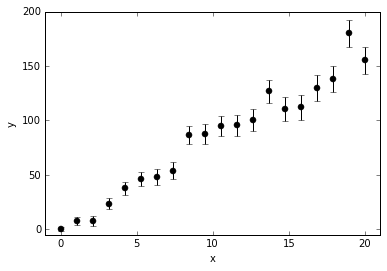

In [17]:
import pylab as pl
import numpy as np
import math
import mcmc as MC
%matplotlib inline

#We have some global variables to be used in our functions:
global xdata,ydata,sigmadata,sigma_pars

#We need to define some functions:

#The model (in our case, 2 parameters for a straight line):
def model(pars,x):
    """return a value for the model based on the parameters
    and one independent coordinate"""
    return pars[0]+pars[1]*x

#A function to calculate chi-squared between data and model:
def chisquare(a,b,sigma):
    """Simple chi-squared between 2 NP arrays. Assumes that sigmas are non-zero!!!"""
    return (((a-b)/sigma)**2).sum()

#A function to calculate the actual likelihood multiplied by the prior (assuming gaussian prior)
def likelihood(pars,pars_constraints):
    """Return likelihood as estimated from a chi-squared and gaussian 
    constraints/priors on parameters"""
    #add terms to chi-squared from prior gaussian constraints
    prior_chi=0
    for i in range(len(pars_constraints)):
        mu,sigma = pars_constraints[i]
        if sigma != 0:
            prior_chi = prior_chi + (pars[i]-mu)**2/sigma**2 
            
    #The total likelihood has the chi-squared from the data and the prior:        
    return math.exp(-0.5*(chisquare(ydata,model(pars,xdata),sigmadata)+prior_chi))

#This is a function needed by MCMC
def proposal_pars(pars):
    """Generate trial parameters based on a gaussian proposal distribution"""
    test_pars=np.random.normal(pars,sigma_pars)
    return test_pars


#The actual data:
xdata=np.array([0.00,1.05,2.11,3.16,4.21,5.26,6.32,7.37,8.42,9.47,10.53,11.58,12.63,
                13.68,14.74,15.79,16.84,17.89,18.95,20.00])
ydata=np.array([0.51,7.80,7.55,23.62,37.59,46.09,48.35,53.67,86.75,87.61,94.84,95.65,
                100.46,126.74,110.95,112.10,129.91,138.07,180.20,155.10])
sigmadata=np.array([1.73,3.38,4.45,5.32,6.06,6.72,7.32,7.87,8.39,8.88,9.34,9.78,10.20,
                    10.61,11.00,11.37,11.74,12.09,12.43,12.77])

#which we plot:
pl.errorbar(xdata,ydata,sigmadata,fmt='o',color='black')
pl.axis([-1,21,-5,200])
pl.xlabel('x')
pl.ylabel('y')
pl.show()

In [18]:
#Now, we use the MCMC algorithm:
#This can be slow if the number of MCMC steps is large!!!

#Initialize the parameters (use the known true values)
start_pars=np.array([3,8])
#Set the sigmas for the proposal distributions
sigma_pars=np.array([1.0,1.0])
#Provide gaussian constraints (priors) for the parameters using mu and sigma
par_constraints = [(0,0),(10,0.1)] #no constraint on a, 10+/-0.1 on b

mcmc=MC.MCMC(start_pars,par_constraints)
mcmc.get_likelihood=likelihood#set the likelihood function
mcmc.get_proposal_pars=proposal_pars#set the proposal function for trial pars
mcmc.run(1000000,1000)#The number of steps, and the number of burnin

results=MC.MCMCResult(mcmc.accepted[mcmc.burnin:])

#pull out the accepted values of each parameter
par0 = mcmc.accepted[mcmc.burnin:,0]
par1 = mcmc.accepted[mcmc.burnin:,1]

#print out the resulting mean and standard deviation for the parameters
print("par0 : = {:.2f} +/- {:.2f}".format(par0.mean(),par0.std(ddof=1)))
print("par1 : = {:.2f} +/- {:.2f}".format(par1.mean(),par1.std(ddof=1)))


par0 : = -5.17 +/- 1.21
par1 : = 9.75 +/- 0.09


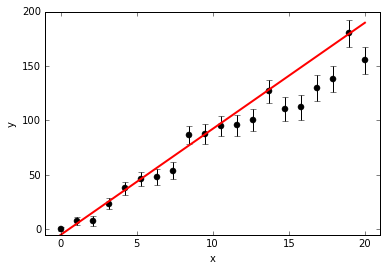

In [5]:

pl.errorbar(xdata,ydata,sigmadata,fmt='o',color='black')
pl.plot(xdata,model((par0.mean(),par1.mean()),xdata),color='red',lw=2)
pl.axis([-1,21,-5,200])
pl.xlabel('x')
pl.ylabel('y')
pl.show()

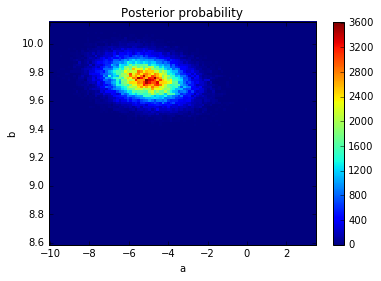

In [14]:
#The 2D posterior:
pl.hist2d(mcmc.accepted[:,0],mcmc.accepted[:,1],bins=100)
pl.xlabel('a')
pl.ylabel('b')
pl.title('Posterior probability')
pl.colorbar()
pl.show()



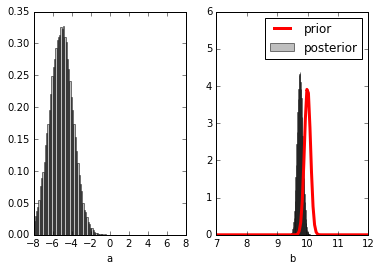

In [15]:
#The two 1-D posteriors:
import scipy.stats as stats

pl.Figure()
pl.subplot(121)
n,bins,patches=pl.hist(mcmc.accepted[:,0],bins=100, color='gray', alpha=0.5, normed=True)
pl.xlabel('a')
pl.axis([-8,8,0,0.35])
pl.subplot(122)
n,bins,patches=pl.hist(mcmc.accepted[:,1],bins=100, color='gray', alpha=0.5, normed=True,label='posterior')
bw=bins[2]-bins[1]
pl.axis([7,12,0,6.])
xi = np.linspace(7,12,100)
mu,sigma = par_constraints[1]
pl.plot(xi,stats.norm.pdf(xi,mu,sigma),color='red',lw=3,label='prior')
pl.xlabel('b')
pl.legend(loc='best')
pl.show()